In [18]:
import torch
import numpy as np
import pickle
from lpne.models import DcsfaNmf
from lpne.plotting import circle_plot
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from PIL import Image
import matplotlib.pyplot as plt
import os, sys
from sklearn.model_selection import KFold

umc_data_tools_path = "/hpc/home/mk423/Anxiety/Universal-Mouse-Code/"
sys.path.append(umc_data_tools_path)
import umc_data_tools as umc_dt

flx_data_path = "/work/mk423/Anxiety/final_FLX_{}.pkl"
epm_data_path = "/work/mk423/Anxiety/EPM_{}_dict_May_17.pkl"
oft_data_path = "/work/mk423/Anxiety/OFT_{}_dict_old_features_hand_picked.pkl"

anx_info_dict = "/work/mk423/Anxiety/Anx_Info_Dict.pkl"

saved_model_path = "/hpc/home/mk423/Anxiety/FullDataWork/Models/"
saved_model_name = "all_mt_model.pt"

projection_save_path = "/hpc/home/mk423/Anxiety/FullDataWork/Projections/"
plots_path = "/hpc/home/mk423/Anxiety/FullDataWork/Figures/"

feature_list = ["X_psd","X_coh","X_gc"]
old_feature_list = ["X_power_1_2","X_coh_1_2","X_gc_1_2"]
feature_weights = [10,1,1]

RANDOM_STATE = 42
kf = KFold(n_splits=4)

In [2]:
with open(flx_data_path.format("train"),"rb") as f:
    train_dict = pickle.load(f)
    
with open(flx_data_path.format("val"),"rb") as f:
    val_dict = pickle.load(f)
    
with open(flx_data_path.format("test"),"rb") as f:
    test_dict = pickle.load(f)
    
flx_X_train = np.hstack([train_dict[feature]*weight for feature,weight in zip(feature_list,feature_weights)])
flx_y_train = train_dict['y_flx']
flx_y_mouse_train = train_dict['y_mouse']
flx_y_hab_train = train_dict['y_hab']
flx_y_time_train = train_dict['y_time']

flx_X_val = np.hstack([val_dict[feature]*weight for feature,weight in zip(feature_list,feature_weights)])
flx_y_val = val_dict['y_flx']
flx_y_mouse_val = val_dict['y_mouse']
flx_y_hab_val = val_dict['y_hab']
flx_y_time_val = val_dict['y_time']

flx_X_test = np.hstack([test_dict[feature]*weight for feature,weight in zip(feature_list,feature_weights)])
flx_y_test = test_dict['y_flx']
flx_y_mouse_test = test_dict['y_mouse']
flx_y_hab_test = test_dict['y_hab']
flx_y_time_test = test_dict['y_time']


In [3]:
overlap_mice = ['Mouse3191', 'Mouse3192', 'Mouse3193', 'Mouse3194', 'Mouse3203']
always_train_mice = ["Mouse3202","Mouse99002","Mouse99003","Mouse99021"]
train_mice = ['Mouse3191', 'Mouse3192', 'Mouse3193', 'Mouse3194', 'Mouse3203']
val_mice = ['Mouse78752', 'Mouse61635', 'Mouse78744', 'Mouse61631']
overlap_train_mice_list = []
overlap_val_mice_list = []

shuffle_mice = train_mice + val_mice

flx_X_kf = np.vstack([flx_X_train[flx_y_hab_train==1],flx_X_val[flx_y_hab_val==1]])
flx_y_kf = np.hstack([flx_y_train[flx_y_hab_train==1],flx_y_val[flx_y_hab_val==1]])
flx_y_mouse_kf = np.hstack([flx_y_mouse_train[flx_y_hab_train==1],flx_y_mouse_val[flx_y_hab_val==1]])
flx_y_time_kf = np.hstack([flx_y_time_train[flx_y_hab_train==1],flx_y_time_val[flx_y_hab_val==1]])

kf = KFold(n_splits=4)
for i, (train_mice,val_mice) in enumerate(kf.split(shuffle_mice)):
    
    print(i,np.array(shuffle_mice)[train_mice],np.array(shuffle_mice)[val_mice])
    
    kf_train_mice = np.hstack([np.array(shuffle_mice)[train_mice],always_train_mice])
    kf_val_mice = np.array(shuffle_mice)[val_mice]
    
    overlap_train_mice_list.append([mouse for mouse in np.unique(kf_train_mice) if mouse in overlap_mice])
    overlap_val_mice_list.append([mouse for mouse in np.unique(kf_val_mice) if mouse in overlap_mice])
    train_mask = np.array([1 if mouse in kf_train_mice else 0 for mouse in flx_y_mouse_kf])
    val_mask = 1-train_mask
    
    fold_dict = {
        "X_train":flx_X_kf[train_mask==1],
        "y_train":flx_y_kf[train_mask==1],
        "y_mouse_train":flx_y_mouse_kf[train_mask==1],
        "y_time_train":flx_y_time_kf[train_mask==1],
        
        "X_val":flx_X_kf[val_mask==1],
        "y_val":flx_y_kf[val_mask==1],
        "y_mouse_val":flx_y_mouse_kf[val_mask==1],
        "y_time_val":flx_y_time_kf[val_mask==1]
    }
    
    with open("/work/mk423/Anxiety/flx_kf_dict_fold_{}.pkl".format(i+1),"wb") as f:
        pickle.dump(fold_dict,f)


0 ['Mouse3194' 'Mouse3203' 'Mouse78752' 'Mouse61635' 'Mouse78744'
 'Mouse61631'] ['Mouse3191' 'Mouse3192' 'Mouse3193']
1 ['Mouse3191' 'Mouse3192' 'Mouse3193' 'Mouse78752' 'Mouse61635'
 'Mouse78744' 'Mouse61631'] ['Mouse3194' 'Mouse3203']
2 ['Mouse3191' 'Mouse3192' 'Mouse3193' 'Mouse3194' 'Mouse3203' 'Mouse78744'
 'Mouse61631'] ['Mouse78752' 'Mouse61635']
3 ['Mouse3191' 'Mouse3192' 'Mouse3193' 'Mouse3194' 'Mouse3203' 'Mouse78752'
 'Mouse61635'] ['Mouse78744' 'Mouse61631']


In [4]:
overlap_train_mice_list

[['Mouse3194', 'Mouse3203'],
 ['Mouse3191', 'Mouse3192', 'Mouse3193'],
 ['Mouse3191', 'Mouse3192', 'Mouse3193', 'Mouse3194', 'Mouse3203'],
 ['Mouse3191', 'Mouse3192', 'Mouse3193', 'Mouse3194', 'Mouse3203']]

In [5]:
overlap_val_mice_list

[['Mouse3191', 'Mouse3192', 'Mouse3193'], ['Mouse3194', 'Mouse3203'], [], []]

In [6]:
with open(oft_data_path.format("train"),'rb') as f:
    train_dict = pickle.load(f)

with open(oft_data_path.format("validation"),'rb') as f:
    val_dict = pickle.load(f)
    
with open(oft_data_path.format("test"),'rb') as f:
    test_dict = pickle.load(f)
    

running_idx = 0
feature_groups = []
for idx,feature in enumerate(old_feature_list):
    f_begin = running_idx
    f_end = f_begin + train_dict[feature].shape[1] 
    if idx == 0:
        f_end = f_end -1
    feature_groups.append((f_begin,f_end))

    running_idx = f_end

NUM_FREQS = 56
NUM_FEATURES = np.hstack([train_dict[feature] for feature in old_feature_list]).shape[1] // NUM_FREQS
scale_vector = np.array([np.arange(1,NUM_FREQS+1) for feature in range(NUM_FEATURES)]).flatten()

#Train Arrays
oft_X_train = np.hstack([train_dict[feature]*weight for feature,weight in zip(old_feature_list,feature_weights)])
oft_y_hc_train = train_dict['y_Homecage'].astype(bool)
oft_y_task_train = ~oft_y_hc_train
oft_y_ROI_train = train_dict['y_ROI']
oft_y_vel_train = train_dict['y_vel']
oft_y_mouse_train = train_dict['y_mouse']
oft_y_time_train = train_dict['y_time']

#Validation Arrays
oft_X_val = np.hstack([val_dict[feature]*weight for feature,weight in zip(old_feature_list,feature_weights)])
oft_y_hc_val = val_dict['y_Homecage'].astype(bool)
oft_y_task_val = ~oft_y_hc_val
oft_y_ROI_val = val_dict['y_ROI']
oft_y_vel_val = val_dict['y_vel']
oft_y_mouse_val = val_dict['y_mouse']
oft_y_time_val = val_dict['y_time']

#Test Arrays
oft_X_test = np.hstack([test_dict[feature]*weight for feature,weight in zip(old_feature_list,feature_weights)])
oft_y_hc_test = test_dict['y_Homecage'].astype(bool)
oft_y_task_test = ~oft_y_hc_test
oft_y_ROI_test = test_dict['y_ROI']
oft_y_vel_test = test_dict['y_vel']
oft_y_mouse_test = test_dict['y_mouse']
oft_y_time_test = test_dict['y_time']

oft_X = np.vstack([oft_X_train,oft_X_val])
oft_y_task = np.hstack([oft_y_task_train,oft_y_task_val])
oft_y_mouse = np.hstack([oft_y_mouse_train,oft_y_mouse_val])

In [7]:
print(np.unique(oft_y_mouse_train))
print(np.unique(oft_y_mouse_val))

['Mouse04191' 'Mouse04201' 'Mouse04202' 'Mouse04205' 'Mouse04215'
 'Mouse3191' 'Mouse3192' 'Mouse3193' 'Mouse3194' 'Mouse3203' 'Mouse39114'
 'Mouse39124' 'Mouse39133' 'Mouse69064' 'Mouse69072' 'Mouse69074']
['Mouse04193' 'Mouse39125' 'Mouse69065']


In [8]:
default_train_mice = []
for mouse in np.unique(oft_y_mouse):
    mouse_mask = (oft_y_mouse==mouse)
    
    if len(np.unique(oft_y_task[mouse_mask==1])) < 2:
        default_train_mice.append(mouse)

In [9]:
default_train_mice

['Mouse04215', 'Mouse3192', 'Mouse3194', 'Mouse3203']

In [12]:
kf_mice = np.unique(oft_y_mouse)

kf_mice = np.array([mouse for mouse in np.unique(oft_y_mouse) if mouse not in default_train_mice])

for i, (train_idxs,val_idxs) in enumerate(kf.split(kf_mice)):
    
    flx_fold_train_mice = overlap_train_mice_list[i]
    flx_fold_val_mice = overlap_val_mice_list[i]
    
    kf_train_mice = np.hstack([kf_mice[train_idxs],default_train_mice])
    kf_val_mice = kf_mice[val_idxs]
    print(kf_train_mice,kf_val_mice)
    print(flx_fold_train_mice,flx_fold_val_mice)
    
    if (len(np.intersect1d(flx_fold_train_mice,kf_train_mice)) != len(flx_fold_train_mice)) or (len(np.intersect1d(flx_fold_val_mice,kf_val_mice)) != len(flx_fold_val_mice)):
        
        kf_clean_train_mice = [mouse for mouse in kf_train_mice if mouse not in np.union1d(default_train_mice,np.union1d(flx_fold_train_mice,flx_fold_val_mice))]
        kf_clean_val_mice = [mouse for mouse in kf_val_mice if mouse not in np.union1d(default_train_mice,np.union1d(flx_fold_train_mice,flx_fold_val_mice))]
        
        kf_train_to_val = [mouse for mouse in kf_train_mice if mouse in flx_fold_val_mice]
        kf_val_to_train = [mouse for mouse in kf_val_mice if mouse in flx_fold_train_mice]
        
        kf_clean_train_to_val = list(np.random.choice(kf_clean_train_mice,size=len(kf_val_to_train),replace=False))
        kf_clean_val_to_train = list(np.random.choice(kf_clean_val_mice,size=len(kf_train_to_val),replace=False))
        
        kf_stay_train = [mouse for mouse in kf_clean_train_mice if mouse not in kf_clean_train_to_val]
        kf_stay_val = [mouse for mouse in kf_clean_val_mice if mouse not in kf_clean_val_to_train]
        
        kf_train_mice = np.hstack((kf_stay_train,kf_clean_val_to_train,kf_val_to_train))
        kf_val_mice = np.hstack((kf_stay_val,kf_clean_train_to_val,kf_train_to_val))
        
        print("Clean train: {}, Clean Val: {}".format(kf_clean_train_mice,kf_clean_val_mice))
        print("Swap train: {}, Swap Val: {}".format(kf_train_to_val,kf_val_to_train))
        print("Clean Swap Train: {}, Clean Swap Val: {}".format(kf_clean_train_to_val,kf_clean_val_to_train))
        print("swapping")
        print("Train in Val: {}, Val in Train: {}".format(np.intersect1d(kf_train_mice,flx_fold_val_mice),np.intersect1d(kf_val_mice,flx_fold_train_mice)))

    train_mask = np.array([1 if mouse in kf_train_mice else 0 for mouse in oft_y_mouse])
    val_mask = 1 - train_mask
    
    fold_dict = {
        "X_train":oft_X[train_mask==1],
        "y_train":oft_y_task[train_mask==1],
        "y_mouse_train":oft_y_mouse[train_mask==1],
        
        "X_val":oft_X[val_mask==1],
        "y_val":oft_y_task[val_mask==1],
        "y_mouse_val":oft_y_mouse[val_mask==1],
    }

    with open("/work/mk423/Anxiety/oft_kf_dict_fold_{}.pkl".format(i+1),"wb") as f:
        pickle.dump(fold_dict,f)

['Mouse04205' 'Mouse3191' 'Mouse3193' 'Mouse39114' 'Mouse39124'
 'Mouse39125' 'Mouse39133' 'Mouse69064' 'Mouse69065' 'Mouse69072'
 'Mouse69074' 'Mouse04215' 'Mouse3192' 'Mouse3194' 'Mouse3203'] ['Mouse04191' 'Mouse04193' 'Mouse04201' 'Mouse04202']
['Mouse3194', 'Mouse3203'] ['Mouse3191', 'Mouse3192', 'Mouse3193']
Clean train: ['Mouse04205', 'Mouse39114', 'Mouse39124', 'Mouse39125', 'Mouse39133', 'Mouse69064', 'Mouse69065', 'Mouse69072', 'Mouse69074'], Clean Val: ['Mouse04191', 'Mouse04193', 'Mouse04201', 'Mouse04202']
Swap train: ['Mouse3191', 'Mouse3193', 'Mouse3192'], Swap Val: []
Clean Swap Train: [], Clean Swap Val: ['Mouse04201', 'Mouse04202', 'Mouse04191']
swapping
Train in Val: [], Val in Train: []
['Mouse04191' 'Mouse04193' 'Mouse04201' 'Mouse04202' 'Mouse39124'
 'Mouse39125' 'Mouse39133' 'Mouse69064' 'Mouse69065' 'Mouse69072'
 'Mouse69074' 'Mouse04215' 'Mouse3192' 'Mouse3194' 'Mouse3203'] ['Mouse04205' 'Mouse3191' 'Mouse3193' 'Mouse39114']
['Mouse3191', 'Mouse3192', 'Mouse3193

In [42]:
np.union1d

<function numpy.union1d(ar1, ar2)>

In [15]:
with open(epm_data_path.format("train"),"rb") as f:
    epm_train_dict = pickle.load(f)

with open(epm_data_path.format("val"),"rb") as f:
    epm_validation_dict = pickle.load(f)
    
with open(epm_data_path.format("test"),"rb") as f:
    epm_test_dict = pickle.load(f)

#Load the data
NUM_FREQS = 56
NUM_FEATURES = (epm_train_dict["X_power_1_2"].shape[1] + \
                epm_train_dict["X_coh_1_2"].shape[1] + \
                epm_train_dict["X_gc_1_2"].shape[1]) // NUM_FREQS
SCALE_VECTOR = np.array([np.arange(1,57) for feature in range(NUM_FEATURES)]).flatten()

X_train = np.hstack([epm_train_dict[feature]*weight for feature,weight in zip(old_feature_list,feature_weights)])
X_train[X_train<0] = 0
y_train = (epm_train_dict['y_ROI']%2).astype(bool)
y_in_task_mask_train = ~epm_train_dict['y_Homecage'].astype(bool)
y_mouse_train = epm_train_dict['y_mouse']
y_time_train = epm_train_dict['y_time']
train_nan_mask = (epm_train_dict['y_ROI'] > 0)


X_train_task = X_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
y_train_task = y_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
y_mouse_train_task = y_mouse_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
y_time_train_task = y_time_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
X_val = np.hstack([epm_validation_dict[feature]*weight for feature,weight in zip(old_feature_list,feature_weights)])


y_val = (epm_validation_dict['y_ROI']%2).astype(bool)
y_in_task_mask_val= ~epm_validation_dict['y_Homecage'].astype(bool)
y_mouse_val = epm_validation_dict['y_mouse']
y_time_val = epm_validation_dict['y_time']
val_nan_mask = (epm_validation_dict['y_ROI'] > 0)

X_val_task = X_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]
y_val_task = y_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]
y_mouse_val_task = y_mouse_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]
y_time_val_task = y_time_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]

X_test = np.hstack([epm_test_dict[feature]*weight for feature,weight in zip(old_feature_list,feature_weights)])
y_test = (epm_test_dict['y_ROI']%2).astype(bool)
y_in_task_mask_test= ~epm_test_dict['y_Homecage'].astype(bool)
y_mouse_test = epm_test_dict['y_mouse']
y_time_test = epm_test_dict['y_time']
test_nan_mask = (epm_test_dict['y_ROI'] > 0)

X_test_task = X_test[np.logical_and(y_in_task_mask_test==1,test_nan_mask)==1]
y_test_task = y_test[np.logical_and(y_in_task_mask_test==1,test_nan_mask)==1]
y_mouse_test_task = y_mouse_test[np.logical_and(y_in_task_mask_test==1,test_nan_mask)==1]
y_time_test_task = y_time_test[np.logical_and(y_in_task_mask_test==1,test_nan_mask)==1]

epm_X = np.vstack([X_train,X_val])
epm_y_task = np.hstack([y_in_task_mask_train,y_in_task_mask_val])
epm_y_mouse = np.hstack([y_mouse_train,y_mouse_val])
epm_y_time = np.hstack([y_time_train,y_time_val])


In [11]:
np.unique(epm_train_dict['y_ROI'][epm_train_dict['y_ROI'] >=0])

array([1, 2, 3, 4, 5], dtype=int32)

(array([  884.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 11564.]),
 array([-2.14748365e+09, -1.93273528e+09, -1.71798692e+09, -1.50323855e+09,
        -1.28849019e+09, -1.07374182e+09, -8.58993456e+08, -6.44245091e+08,
        -4.29496726e+08, -2.14748360e+08,  5.00000000e+00]),
 <BarContainer object of 10 artists>)

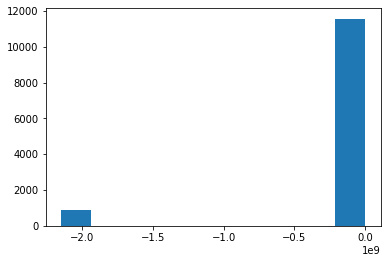

In [9]:
import matplotlib.pyplot as plt

epm_train_dict['y_ROI'] >

In [6]:
epm_y_task.shape

(10525,)

In [44]:
print(np.unique(y_mouse_train))
print(np.unique(y_mouse_val))
print(np.unique(y_mouse_test))

['Mouse04201' 'Mouse04202' 'Mouse04205' 'Mouse04215' 'Mouse0630'
 'Mouse0634' 'Mouse0643' 'Mouse1551' 'Mouse39114' 'Mouse39124'
 'Mouse39133' 'Mouse6291' 'Mouse6292' 'Mouse6293' 'Mouse69064'
 'Mouse69074' 'Mouse8580' 'Mouse8581' 'Mouse8582' 'Mouse8891' 'Mouse8894']
['Mouse04193' 'Mouse0633' 'Mouse0642' 'Mouse39125' 'Mouse69065']
['Mouse0641' 'Mouse39115' 'Mouse39121' 'Mouse39122' 'Mouse39132'
 'Mouse39135' 'Mouse6674' 'Mouse69061' 'Mouse69071' 'Mouse69075'
 'Mouse8893']


In [19]:
kf_mice = np.unique(epm_y_mouse)
for i, (train_idxs,val_idxs) in enumerate(kf.split(kf_mice)):
    kf_train_mice = kf_mice[train_idxs]
    kf_val_mice = kf_mice[val_idxs]
    
    train_mask = np.array([1 if mouse in kf_train_mice else 0 for mouse in epm_y_mouse])
    val_mask = 1 - train_mask
    
    fold_dict = {
        "X_train":epm_X[train_mask==1],
        "y_train":epm_y_task[train_mask==1],
        "y_mouse_train":epm_y_mouse[train_mask==1],
        
        "X_val":epm_X[val_mask==1],
        "y_val":epm_y_task[val_mask==1],
        "y_mouse_val":epm_y_mouse[val_mask==1],
    }
    
    with open("/work/mk423/Anxiety/epm_kf_dict_fold_{}.pkl".format(i+1),"wb") as f:
        pickle.dump(fold_dict,f)

In [12]:
np.sum(y_train)/len(y_train)

0.7659865038560412

In [13]:
np.sum(y_in_task_mask_train)/len(y_in_task_mask_train)

0.6744858611825193